Data processing https://dcase-repo.github.io/dcase_util/tutorial_data.html

In [1]:
import dcase_util as du
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import librosa
import librosa.display as disp

Normalization https://dcase-repo.github.io/dcase_util/tutorial_data.html#normalization

In [2]:
### Calculating normalization factors file-by-file

data = du.utils.Example.feature_container()

# Initialize normalizer
normalizer = du.data.Normalizer()

# Accumulate -- feed data per file in
normalizer.accumulate(data=data)

# After accumulation calculate normalization factors (mean + std)
normalizer.finalize()

# Save
normalizer.save(filename='norm_factors.cpickle')

# Load
normalizer = du.data.Normalizer().load(filename='norm_factors.cpickle')

In [3]:
### Using with statement

data = du.utils.Example.feature_container()

# Accumulate
with du.data.Normalizer() as normalizer:
    normalizer.accumulate(data=data)

# Save
normalizer.save(filename='norm_factors.cpickle')

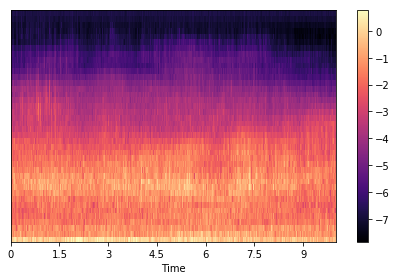

In [4]:
### Initializing normalizer with pre-calculated values

data = du.utils.Example.feature_container()
data.plot()

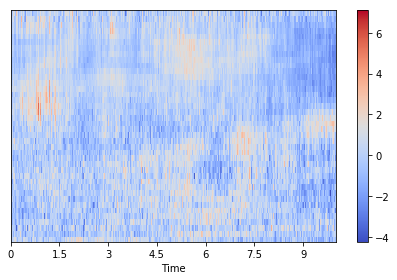

In [5]:
### Normalize data
normalizer = du.data.Normalizer(
    **data.stats
)
normalizer = du.data.Normalizer().load(filename='norm_factors.cpickle')
norm_data = normalizer.normalize(data)
norm_data.plot()

Aggregation https://dcase-repo.github.io/dcase_util/tutorial_data.html#aggregation

Data aggregator class (`dcase_util.data.Aggregator`) can be used to process data matrix in a sliding processing window. This processing stage can be used to collapse data with certain window lengths by calculating mean and std of them, or flatten the matrix into single vector.

Supported processing methods:

`flatten`
`mean`
`std`
`cov`
`kurtosis`
`skew`

All of these processing methods can combined.

(40, 501)
(80, 501)


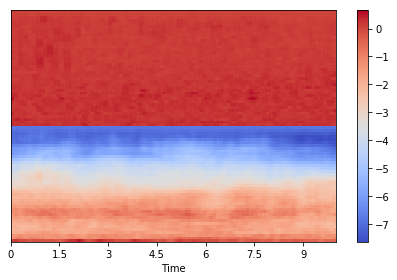

In [6]:
### Flattening data matrix with 10 frames into one single vector, with 1 frame hop:
data = du.utils.Example.feature_container()
print(data.shape)

data_aggregator = du.data.Aggregator(
    recipe=['mean','std'],
    win_length_frames=10,
    hop_length_frames=1,
)
data = data_aggregator.aggregate(data)
print(data.shape)
data.plot()

Sequencing https://dcase-repo.github.io/dcase_util/tutorial_data.html#sequencing

Sequencer class (`dcase_util.data.Sequencer`) processes data matrices into sequences (images). Sequences can overlap, and sequencing grid can be altered between calls (shifted).

(40, 501)
(40, 10, 5)


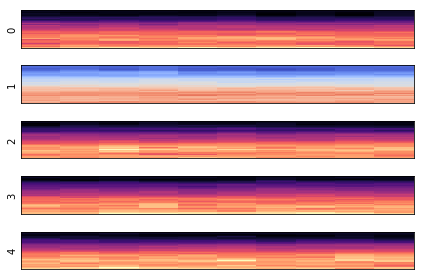

DataMatrix3DContainer :: Class
  Data
    data                            : matrix (40,10,5) 
    Dimensions
      time_axis                     : 1 
    Timing information
      time_resolution               : None 
  Meta
    stats                           : Calculated 
    metadata                        : - 
    processing_chain                : - 
  Duration
    Frames                          : 10 
  Data
    Dimensions
      time_axis                     : 1 
      data_axis                     : 0 
      sequence_axis                 : 2 



In [7]:
data = du.utils.Example.feature_container()
print(data.shape) # (40, 501)

data_sequencer = du.data.Sequencer(
    sequence_length=10,
    hop_length=100
)
sequenced_data = data_sequencer.sequence(data)
print(sequenced_data.shape) # (40, 10, 5)

sequenced_data.plot()
sequenced_data.show()

Stacking https://dcase-repo.github.io/dcase_util/tutorial_data.html#stacking

Stacker class (`dcase_util.data.Stacker`) stacks the data stored in the data repository based on recipe. This class can be used, for example, to create a new feature matrix containing data extracted with multiple feature extractors. With a recipe one can either select full matrix, only part of data vectors with start and end index, or select individual data rows.

['centroid', 'mel', 'mfcc', 'mfcc_acceleration', 'mfcc_delta', 'rmse', 'zcr']
(40, 501)


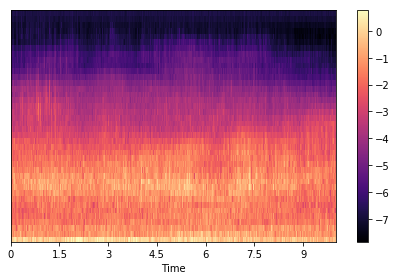

(40, 501)


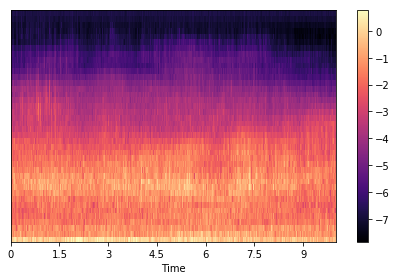

(60, 501)


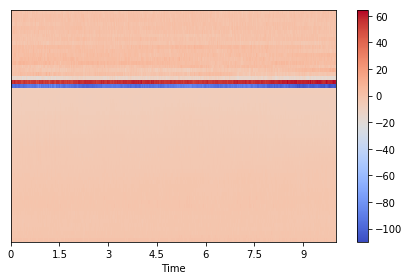

(19, 501)


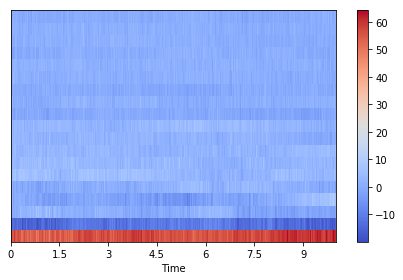

(3, 501)


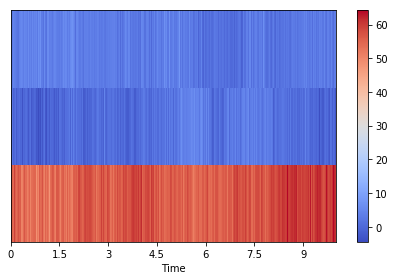

In [8]:
# Load data repository
repo = du.utils.Example.feature_repository()

# Show labels in the repository
print(repo.labels)

# Select full matrix from 'mel' and with default stream (0) (40 mel bands).
data = du.data.Stacker(recipe='mel').stack(repo)
print(data.shape) # (40, 501)
data.plot()

# Select full matrix from 'mel' and define stream 0 (40 mel bands).
data = du.data.Stacker(recipe='mel=0').stack(repo)
print(data.shape) # (40, 501)
data.plot()

# Select full matrix from 'mel' and 'mfcc' with default stream (0) (40 mel bands + 20 mfccs).
data = du.data.Stacker(recipe='mel;mfcc').stack(repo)
print(data.shape) # (60, 501)
data.plot()

# Select data from 'mfcc' matrix with default stream (0), and omit first coefficient (19 mfccs).
data = du.data.Stacker(recipe='mfcc=1-19').stack(repo)
print(data.shape) # (19, 501)
data.plot()

# Select data from 'mfcc' matrix with default stream (0), select coefficients 1,5,7 (3 mfccs).
data = du.data.Stacker(recipe='mfcc=1,5,7').stack(repo)
print(data.shape) # (3, 501)
data.plot()


Data Encoding https://dcase-repo.github.io/dcase_util/tutorial_data.html#data-encoding

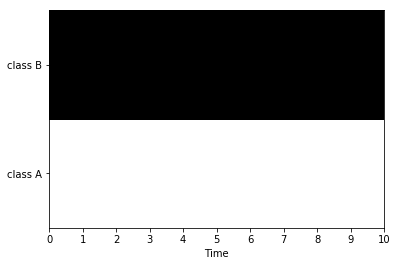

In [9]:
### One-hot

# Initilize encoder
onehot_encoder = du.data.OneHotEncoder(
    label_list=['class A','class B'],
    time_resolution=0.02
)

# Encode
binary_matrix = onehot_encoder.encode(
    label='class B',
    length_seconds=10.0
)

# Visualize
binary_matrix.plot()

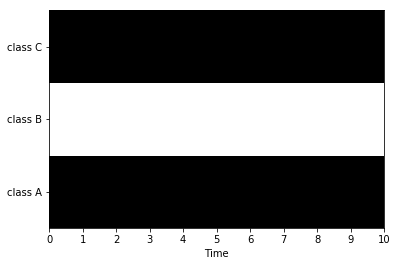

In [10]:
### Many-hot

# Initilize encoder
manyhot_encoder = du.data.ManyHotEncoder(
    label_list=['class A','class B','class C'],
    time_resolution=0.02
)

# Encode
binary_matrix = manyhot_encoder.encode(
    label_list=['class A', 'class C'],
    length_seconds=10.0
)

# Visualize
binary_matrix.plot()

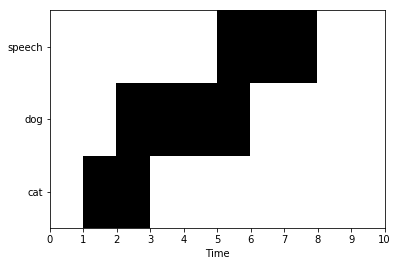

In [11]:
### Event roll

# Metadata
meta = du.containers.MetaDataContainer([
    {
        'filename': 'test1.wav',
        'event_label': 'cat',
        'onset': 1.0,
        'offset': 3.0
    },
    {
        'filename': 'test1.wav',
        'event_label': 'dog',
        'onset': 2.0,
        'offset': 6.0
    },
    {
        'filename': 'test1.wav',
        'event_label': 'speech',
        'onset': 5.0,
        'offset': 8.0
    },
])

# Initilize encoder
event_roll_encoder = du.data.EventRollEncoder(
    label_list=meta.unique_event_labels,
    time_resolution=0.02
)

# Encode
event_roll = event_roll_encoder.encode(
    metadata_container=meta,
    length_seconds=10.0
)

# Visualize
event_roll.plot()

Probability Encoding https://dcase-repo.github.io/dcase_util/tutorial_data.html#probability-encoding

In [12]:
### Collapsing matrix over time axis to vector with per class values:

p = du.data.ProbabilityEncoder()

probabilities = np.array(
    [[0.2, 0.3, 0.1],
     [0.4, 0.6, 0.7]]
)

out = p.collapse_probabilities(
    probabilities=probabilities,
    time_axis=0,
    operator='prod'
)
print(type(out),out)

<class 'numpy.ndarray'> [0.08 0.18 0.07]


In [13]:
### Collapsing data in the matrix with sliding window over time axis:

p = du.data.ProbabilityEncoder()

probabilities = np.array(
    [
        [0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2],
        [0.1, 0.3, 0.3],
        [0.1, 0.1, 0.1],
    ]
)

out = p.collapse_probabilities_windowed(
    probabilities=probabilities,
    operator='sliding_sum',
    window_length=2,
    time_axis=1
)
print(out)
# [[0.2 0.1 0.1]
#  [0.4 0.2 0.2]
#  [0.4 0.3 0.3]
#  [0.2 0.1 0.1]]

[[0.2 0.1 0.1]
 [0.4 0.2 0.2]
 [0.4 0.3 0.3]
 [0.2 0.1 0.1]]


In [14]:
### Binarizing probabilities in the matrix with global threshold:

p = du.data.ProbabilityEncoder()

probabilities = np.array(
    [
        [0.1, 0.5, 0.1],
        [0.2, 0.2, 0.2],
        [0.1, 0.6, 0.7],
        [0.1, 0.6, 0.6],
    ]
)
out = p.binarization(
    probabilities=probabilities,
    binarization_type='global_threshold',
    threshold=0.5,
    time_axis=1
)
print(out)
# [[0 1 0]
#  [0 0 0]
#  [0 1 1]
#  [0 1 1]]

[[0 1 0]
 [0 0 0]
 [0 1 1]
 [0 1 1]]


In [15]:
# Binarizing probabilities in the matrix with class-wise thresholds:

p = du.data.ProbabilityEncoder()

probabilities = np.array(
    [
        [0.1, 0.5, 0.1],
        [0.2, 0.2, 0.2],
        [0.1, 0.6, 0.7],
        [0.1, 0.6, 0.6],
    ]
)
out = p.binarization(
    probabilities=probabilities,
    binarization_type='class_threshold',
    threshold=[0.5, 0.2, 0.1, 0.4],
    time_axis=1
)
print(out)
# [[0 1 0]
#  [1 1 1]
#  [1 1 1]
#  [0 1 1]]

[[0 1 0]
 [1 1 1]
 [1 1 1]
 [0 1 1]]


In [16]:
### Binarizing probabilities in the matrix with frame wise max:

p = du.data.ProbabilityEncoder()

probabilities = np.array(
    [
        [0.1, 0.5, 0.1],
        [0.2, 0.2, 0.2],
        [0.1, 0.6, 0.7],
        [0.1, 0.6, 0.6],
    ]
)
out = p.binarization(
    probabilities=probabilities,
    binarization_type='frame_max',
    time_axis=1
)
print(out)
# [[0 0 0]
#  [1 0 0]
#  [0 1 1]
#  [0 1 0]]

[[0 0 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]]


Decision Encoding https://dcase-repo.github.io/dcase_util/tutorial_data.html#decision-encoding

In [18]:
### Majority vote:

d = du.data.DecisionEncoder(label_list=['A', 'B', 'C'])

activity_matrix = np.array([
    [0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0]
])

out = d.majority_vote(
    frame_decisions=activity_matrix,
    time_axis=1
)
print(out)
# B

B


In [19]:
### Many hot encoding:

d = du.data.DecisionEncoder(label_list=['A', 'B', 'C'])

activity_matrix = np.array([
    [1, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 1, 0]
])

out = d.many_hot(
    frame_decisions=activity_matrix,
    time_axis=1
)
print(out)
# [['A', 'C'], ['B'], ['B'], ['A', 'C'], ['A', 'C'], ['B']]

[['A', 'C'], ['B'], ['B'], ['A', 'C'], ['A', 'C'], ['B']]


In [20]:
### Translating activity array into start and end index pairs:

activity_array = np.array([1, 1, 1, 0, 0, 1, 1, 0, 1])
d = du.data.DecisionEncoder()
out = d.find_contiguous_regions(
    activity_array=activity_array
)
print(out)
# [[0 3]
#  [5 7]
#  [8 9]]

[[0 3]
 [5 7]
 [8 9]]


In [24]:
### Filter activity matrix with median filter:

activity_matrix = np.array([
    [0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 1],
    [1, 0, 0, 1, 0, 0]
])
d = du.data.DecisionEncoder()
out = d.process_activity(
    activity_matrix=activity_matrix,
    window_length=3,
    time_axis=1
)
print(out)
# [[0 0 0 1 1 0]
#  [0 1 1 1 1 1]
#  [0 0 0 0 0 0]]

[[0 0 0 1 1 0]
 [0 1 1 1 1 1]
 [0 0 0 0 0 0]]
